## Sega Genesis map.jim Format Extractor

This notebook helps analyze and extract components from *.map.jim format files used in Sega Genesis/Mega Drive development.

Components we'll extract:
1. Header information
2. Palette data (with visualization)
3. Stamp/tile data
4. Map data

In [2]:
# Methods for extracting data from a Jim file

import struct
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# For visual tile display
from PIL import Image
import io

class JimExtractor:
    def __init__(self, filename):
        self.data = Path(filename).read_bytes()        
        self.extract_header()
    
    def returnBaseFile(self):
        return self.data
    
    def read_long(self, offset):
        """Read a 32-bit big-endian value."""
        return struct.unpack('>L', self.data[offset:offset+4])[0]
    
    def read_word(self, offset):
        """Read a 16-bit big-endian value."""
        return struct.unpack('>H', self.data[offset:offset+2])[0]
    
    def extract_header(self):
        """Extract header information."""
        self.pal_offset = self.read_long(0)  # Palette offset start
        self.map_offset = self.read_long(4)  # Map offset start
        self.num_stamps = self.read_word(8)
        
    def print_header_info(self):
        """Display header information nicely formatted."""
        print("Header Information:")
        print(f"├── Palette Offset: {self.pal_offset} (0x{self.pal_offset:X}) to {self.pal_offset + 128} (0x{self.pal_offset + 128:X})")
        print(f"├── Map Offset: {self.map_offset} (0x{self.map_offset:X}) to {self.map_offset + 4 + (self.read_word(self.map_offset) * self.read_word(self.map_offset + 2) * 2)} (0x{self.map_offset + 4 + (self.read_word(self.map_offset) * self.read_word(self.map_offset + 2) * 2):X})")
        print(f"└── Stamps Offset: 10 to {self.pal_offset} (0x{self.pal_offset:X})")
    
    def extract_palette(self):
        """Extract and convert palette data to RGB values."""
        pal_data = self.data[self.pal_offset:self.pal_offset + 128]  # Palette offset end
        colors = []
        
        for i in range(0, 128, 2):
            color = struct.unpack('>H', pal_data[i:i+2])[0]
            # Genesis format: 0000 bbb0 ggg0 rrr0
            r = ((color & 0x000E) >> 1) * 32
            g = ((color & 0x00E0) >> 5) * 32
            b = ((color & 0x0E00) >> 9) * 32
            colors.append((r, g, b))
            
        return colors
    
    def visualize_palette(self):
        """Create a visual representation of the palette."""
        colors = self.extract_palette()
        fig, ax = plt.subplots(4, 16, figsize=(16, 4))
        fig.suptitle('Genesis Palette (64 Colors)')
        
        for i, color in enumerate(colors):
            row = i // 16
            col = i % 16
            ax[row, col].set_facecolor([x/255 for x in color])
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            
        plt.tight_layout()
        plt.show()
    
    def extract_stamps(self):
        """Extract stamp/tile data."""
        return self.data[10:self.pal_offset]  # Stamps offset end
    
    def extract_map(self):
        """Extract map data and dimensions."""
        width = self.read_word(self.map_offset)
        height = self.read_word(self.map_offset + 2)
        map_data = self.data[self.map_offset + 4:self.map_offset + 4 + (width * height * 2)]  # Map offset end
        return width, height, map_data
    
    def visualize_stamps(self, stamps_per_row=8):
        """Create a visual representation of the stamps (8x8 pixel tiles)."""
        stamp_data = self.extract_stamps()
        stamps_total = len(stamp_data) // 32  # 32 bytes per 8x8 tile
        
        # Create a blank image
        rows = (stamps_total + stamps_per_row - 1) // stamps_per_row
        img = np.zeros((rows * 8, stamps_per_row * 8), dtype=np.uint8)
        
        for stamp_idx in range(stamps_total):
            row = (stamp_idx // stamps_per_row) * 8
            col = (stamp_idx % stamps_per_row) * 8
            
            # Process 32 bytes of tile data
            tile_data = stamp_data[stamp_idx*32:(stamp_idx+1)*32]
            
            # Convert planar data to 8x8 tile
            for y in range(8):
                for x in range(8):
                    pixel = 0
                    for plane in range(4):
                        bit = (tile_data[y*4 + plane] >> (7-x)) & 1
                        pixel |= bit << plane
                    img[row + y, col + x] = pixel
        
        plt.figure(figsize=(12, 12))
        plt.imshow(img, cmap='gray')
        plt.title(f'Stamp Data ({stamps_total} tiles)')
        plt.axis('off')
        plt.show()

## Load and Analyze a .jim File

Let's load your .jim file and examine its contents:

In [3]:
# Basename of the map.jim file to extract
basename = 'Title1'
jim = JimExtractor(f'src/graphics/{basename}.map.jim')
jim.print_header_info()

Header Information:
├── Palette Offset: 20522 (0x502A) to 20650 (0x50AA)
├── Map Offset: 20650 (0x50AA) to 22446 (0x57AE)
└── Stamps Offset: 10 to 20522 (0x502A)


## Visualize the Palette

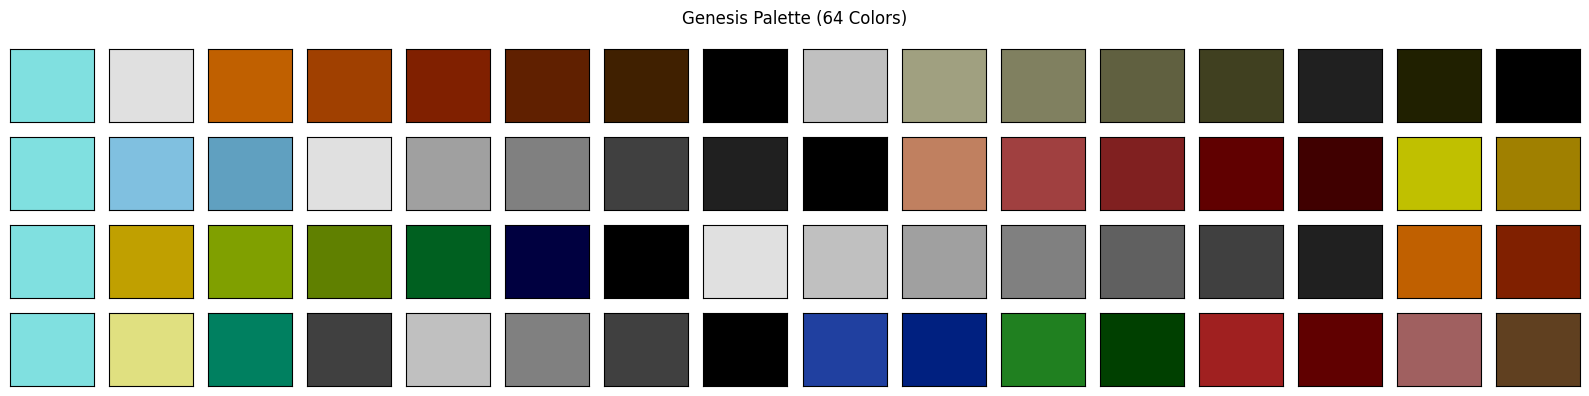

In [4]:
# Visualize palette code
jim.visualize_palette()

## Visualize Stamp/Tile Data

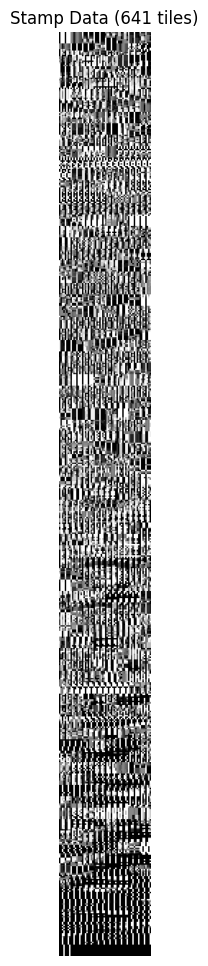

In [5]:
# Visualize Code
jim.visualize_stamps()

## Save Extracted Components

In [6]:
#Save extracted components from jim.map to individual files
import os
from pathlib import Path

def genesis_to_rgb(color):
    """
    Convert Genesis color value (0000 bbb0 ggg0 rrr0) to RGB bytes
    """
    # Genesis: 0000 bbb0 ggg0 rrr0
    r = ((color & 0x000E) >> 1) * 32
    g = ((color & 0x00E0) >> 5) * 32
    b = ((color & 0x0E00) >> 9) * 32
    return bytes([r, g, b])

def save_components(jim, base_name, output_dir=None):
    """
    Save extracted components to specified directory.
    
    Args:
        jim: JimExtractor instance
        base_name: Base name for output files
        output_dir: Directory to save files (creates if doesn't exist)
    
    Returns:
        dict: Paths of saved files
    """
    # Handle output directory
    if output_dir:
        output_path = Path(output_dir)
    else:
        output_path = Path.cwd()
    
    # Create output directory if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)
    
    saved_files = {}
    
    # Save stamps
    stamps_path = output_path / f"{base_name}_stamps.bin"
    with open(stamps_path, "wb") as f:
        f.write(jim.extract_stamps())
    saved_files['stamps'] = stamps_path

    # Save Original .map.jim file
    orgfile_path = output_path / f"{base_name}.map.jim"
    with open(orgfile_path, "wb") as f:
        f.write(jim.returnBaseFile())
    saved_files['Orgfile'] = orgfile_path
    
    # Save palette in RGB .pal format
    palette_bin_path = output_path / f"{base_name}.pal"
    with open(palette_bin_path, "wb") as f:
        # Get raw palette data
        pal_data = jim.data[jim.pal_offset:jim.pal_offset + 128]
        
        # Convert each Genesis color to RGB bytes
        for i in range(0, 128, 2):
            color = struct.unpack('>H', pal_data[i:i+2])[0]
            f.write(genesis_to_rgb(color))
    saved_files['palette_bin'] = palette_bin_path
    
    # Save palette in Genesis format
    palette_gen_path = output_path / f"{base_name}_genesis.pal"
    with open(palette_gen_path, "wb") as f:
        # Save raw Genesis format palette data
        f.write(jim.data[jim.pal_offset:jim.pal_offset + 128])
    saved_files['palette_genesis'] = palette_gen_path
    
    # Also save a human-readable version for reference
    palette_txt_path = output_path / f"{base_name}_palette.txt"
    with open(palette_txt_path, "w") as f:
        pal_data = jim.data[jim.pal_offset:jim.pal_offset + 128]
        for i in range(0, 128, 2):
            color = struct.unpack('>H', pal_data[i:i+2])[0]
            r, g, b = genesis_to_rgb(color)
            f.write(f"Color {i//2:02d}: RGB({r:03d},{g:03d},{b:03d}) - Genesis: 0x{color:04X}\n")
    saved_files['palette_txt'] = palette_txt_path
    
    # Save map
    width, height, map_data = jim.extract_map()
    map_path = output_path / f"{base_name}_map.bin"
    with open(map_path, "wb") as f:
        f.write(struct.pack('>HH', width, height))
        f.write(map_data)
    saved_files['map'] = map_path
    
    # Print summary
    print("Files saved successfully:")
    print(f"└── Directory: {output_path.absolute()}")
    print(f"    ├── Stamps: {stamps_path.name} ({len(jim.extract_stamps())} bytes)")
    print(f"    ├── Palette RGB: {palette_bin_path.name} (64 colors, YYCHR format)")
    print(f"    ├── Palette Genesis: {palette_gen_path.name} (64 colors, Genesis format)")
    print(f"    ├── Palette Text: {palette_txt_path.name} (human readable)")
    print(f"    ├── Map: {map_path.name} ({width}x{height} tiles)")
    print(f"    └── Original Map.Jim: {orgfile_path.name} ")
    
    return saved_files

# Example usage in notebook:
output_directory = "./extracted_data"
save_components(jim, basename, output_directory)

Files saved successfully:
└── Directory: c:\_Personal\NHLHockey\extracted_data
    ├── Stamps: Title1_stamps.bin (20512 bytes)
    ├── Palette RGB: Title1.pal (64 colors, YYCHR format)
    ├── Palette Genesis: Title1_genesis.pal (64 colors, Genesis format)
    ├── Palette Text: Title1_palette.txt (human readable)
    ├── Map: Title1_map.bin (32x28 tiles)
    └── Original Map.Jim: Title1.map.jim 


{'stamps': WindowsPath('extracted_data/Title1_stamps.bin'),
 'Orgfile': WindowsPath('extracted_data/Title1.map.jim'),
 'palette_bin': WindowsPath('extracted_data/Title1.pal'),
 'palette_genesis': WindowsPath('extracted_data/Title1_genesis.pal'),
 'palette_txt': WindowsPath('extracted_data/Title1_palette.txt'),
 'map': WindowsPath('extracted_data/Title1_map.bin')}

## Build PNG from Saved Files


Creating 256x224 indexed image...
Saved indexed color image to: extracted_data/Title1.png
Map dimensions: 32x28 tiles
Number of colors: 64
Total tiles: 641


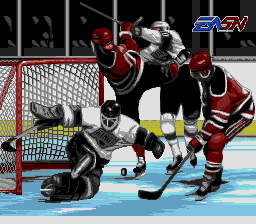

In [7]:
#Build PNG from Saved Files
import numpy as np
from PIL import Image
import struct

def combine_genesis_files(stamps_file, map_file, palette_file, output_file, debug=False):
    """
    Combine Genesis files with proper attribute handling and save as indexed color PNG
    """
    # Read stamps data
    with open(stamps_file, 'rb') as f:
        stamps_data = f.read()
    
    # Read map data
    with open(map_file, 'rb') as f:
        map_width = struct.unpack('>H', f.read(2))[0]
        map_height = struct.unpack('>H', f.read(2))[0]
        map_data = f.read()
    
    # Read and process palette data
    with open(palette_file, 'rb') as f:
        raw_palette_data = f.read()
    
    # Create single flattened palette (64 colors total)
    flat_palette = []
    for pal_line in range(4):
        for i in range(16):
            idx = (pal_line * 16 + i) * 3
            if idx + 2 < len(raw_palette_data):
                r, g, b = raw_palette_data[idx:idx+3]
                flat_palette.extend([r, g, b])
            else:
                flat_palette.extend([0, 0, 0])
    
    # Create palette lookup for each palette line
    palettes = []
    for pal_line in range(4):
        pal = []
        for i in range(16):
            idx = (pal_line * 16 + i) * 3
            if idx + 2 < len(raw_palette_data):
                r, g, b = raw_palette_data[idx:idx+3]
                pal.append((r, g, b))
            else:
                pal.append((0, 0, 0))
        palettes.append(pal)
    
    def decode_4bpp_linear_msx(tile_data, pal_line):
        """
        Decode an 8x8 tile using 4BPP Linear MSX format, returning indexed pixels
        """
        tile = np.zeros((8, 8), dtype=np.uint8)
        
        for y in range(8):
            for x in range(8):
                byte_index = (y * 8 + x) // 2
                bit_shift = 4 if (x % 2) == 0 else 0
                pixel = (tile_data[byte_index] >> bit_shift) & 0x0F
                # Convert to global palette index
                tile[y, x] = pixel + (pal_line * 16)
                
        return tile
    
    def decode_tile_attributes(tile_word):
        """
        Decode Genesis tile attributes from 16-bit word
        """
        priority = (tile_word >> 15) & 1
        pal_line = (tile_word >> 13) & 3
        vflip = (tile_word >> 12) & 1
        hflip = (tile_word >> 11) & 1
        tile_index = tile_word & 0x7FF
        
        return {
            'tile_index': tile_index,
            'palette_line': pal_line,
            'priority': priority,
            'vflip': vflip,
            'hflip': hflip
        }

    def apply_tile_transformations(tile, hflip, vflip):
        """
        Apply flip transformations to a tile
        """
        if hflip:
            tile = np.flip(tile, 1)
        if vflip:
            tile = np.flip(tile, 0)
        return tile
    
    # Create output indexed image
    image_width = map_width * 8
    image_height = map_height * 8
    normal_layer = np.zeros((image_height, image_width), dtype=np.uint8)
    priority_layer = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Process map data
    print(f"Creating {image_width}x{image_height} indexed image...")
    for y in range(map_height):
        for x in range(map_width):
            map_index = (y * map_width + x) * 2
            tile_word = struct.unpack('>H', map_data[map_index:map_index + 2])[0]
            
            attrs = decode_tile_attributes(tile_word)
            tile_index = attrs['tile_index']
            
            if tile_index * 32 < len(stamps_data):
                tile_data = stamps_data[tile_index*32:(tile_index+1)*32]
                # Decode tile with palette line offset
                tile = decode_4bpp_linear_msx(tile_data, attrs['palette_line'])
                
                # Apply flips
                tile = apply_tile_transformations(tile, attrs['hflip'], attrs['vflip'])
                
                # Place in appropriate layer
                target = priority_layer if attrs['priority'] else normal_layer
                target[y*8:(y+1)*8, x*8:(x+1)*8] = tile
                
                if debug and y == 0 and x < 8:
                    print(f"Tile at ({x},{y}): {attrs}")
    
    # Combine layers (priority layer on top)
    full_image = normal_layer.copy()
    mask = priority_layer > 0
    full_image[mask] = priority_layer[mask]
    
    # Convert numpy array to PIL Image with palette
    img = Image.fromarray(full_image, mode='P')
    # Set the palette (PIL expects a flattened list of RGB values)
    img.putpalette(flat_palette)
    
    # Save as PNG with palette information preserved
    img.save(output_file, optimize=False)
    
    print(f"Saved indexed color image to: {output_file}")
    print(f"Map dimensions: {map_width}x{map_height} tiles")
    print(f"Number of colors: {len(flat_palette)//3}")
    print(f"Total tiles: {len(stamps_data)//32}")
    
    return img

# Example usage:
combine_genesis_files(
    stamps_file=f'extracted_data/{basename}_stamps.bin',
    map_file=f'extracted_data/{basename}_map.bin',
    palette_file=f'extracted_data/{basename}.pal',
    output_file=f'extracted_data/{basename}.png',
    debug=False
)

## PNG to map.jim

In [8]:
# PNG back to map.jim file
import numpy as np
from PIL import Image
import struct
from pathlib import Path

class JimWriter:
    def __init__(self, png_file):
        self.image = Image.open(png_file)
        if self.image.mode != 'P':
            raise ValueError("Image must be in indexed color mode")
        
        self.width = self.image.width
        self.height = self.image.height
        self.map_width = self.width // 8
        self.map_height = self.height // 8
        
        self.image_data = np.array(self.image)
        
        # Get PNG palette
        png_palette = self.image.getpalette()
        # Convert PIL palette to Genesis format
        self.new_palette = bytearray()
        for i in range(0, 192, 3):  # Process 64 colors
            if i + 2 < len(png_palette):
                r = (png_palette[i] // 32) << 1     # Convert to Genesis 3-bit
                g = (png_palette[i+1] // 32) << 5   # Convert to Genesis 3-bit
                b = (png_palette[i+2] // 32) << 9   # Convert to Genesis 3-bit
                color_word = r | g | b
                self.new_palette.extend(struct.pack('>H', color_word))
        
        # Pad to 128 bytes if needed
        while len(self.new_palette) < 0x80:
            self.new_palette.extend(b'\x00\x00')
        
        self.tile_cache = {}
        self.next_tile_index = 0
    
    def encode_4bpp_linear_msx(self, tile_data, pal_line):
        """
        Exact reverse of the decode process that worked
        Input: 8x8 numpy array of pixel values
        Output: 32 bytes of planar data
        """
        result = bytearray(32)
        
        # First convert pixels back to their 4-bit values
        for y in range(8):
            for x in range(8):
                pixel = tile_data[y, x]
                if pixel != 0:  # If not transparent
                    pixel = pixel % 16  # Convert back to 4-bit value
                
                # Pack two pixels into one byte
                byte_index = (y * 8 + x) // 2
                if x % 2 == 0:  # First pixel of pair
                    result[byte_index] = pixel << 4
                else:  # Second pixel of pair
                    result[byte_index] |= pixel
        
        return bytes(result)

    def extract_tile(self, x, y):
        """Extract an 8x8 tile and determine its palette line"""
        tile = self.image_data[y:y+8, x:x+8].copy()
        
        # Find most used non-zero palette line
        line_counts = {}
        for pixel in tile.flat:
            if pixel != 0:
                pal_line = pixel // 16
                line_counts[pal_line] = line_counts.get(pal_line, 0) + 1
        
        pal_line = max(line_counts.items(), key=lambda x: x[1])[0] if line_counts else 0
        
        return tile, pal_line
    
    def create_jim_data(self):
        data = bytearray()
        data.extend(bytes(10))  # Placeholder header
        
        # Process tiles and build map
        map_entries = []
        tile_data_list = []
        
        # Process each 8x8 tile
        for y in range(0, self.height, 8):
            for x in range(0, self.width, 8):
                tile, pal_line = self.extract_tile(x, y)
                tile_data = self.encode_4bpp_linear_msx(tile, pal_line)
                
                # Check for duplicate tile
                tile_index = None
                for idx, existing_data in enumerate(tile_data_list):
                    if existing_data == tile_data:
                        tile_index = idx
                        break
                
                if tile_index is None:
                    tile_index = len(tile_data_list)
                    tile_data_list.append(tile_data)
                
                # Create map entry
                map_entry = (pal_line << 13) | tile_index
                map_entries.append(map_entry)
        
        # Add stamp data
        for tile_data in tile_data_list:
            data.extend(tile_data)
        
        # Calculate offsets
        stamps_offset = 10
        pal_offset = stamps_offset + len(tile_data_list) * 32
        map_offset = pal_offset + 0x80
        
        # Add palette data - using new palette from PNG
        data.extend(self.new_palette)
        
        # Add map data
        data.extend(struct.pack('>H', self.map_width))
        data.extend(struct.pack('>H', self.map_height))
        for entry in map_entries:
            data.extend(struct.pack('>H', entry))
        
        # Update header
        header = bytearray()
        header.extend(struct.pack('>L', pal_offset))
        header.extend(struct.pack('>L', map_offset))
        header.extend(struct.pack('>H', len(tile_data_list)))
        data[0:10] = header
        
        return data
    
    def save(self, output_file):
        data = self.create_jim_data()
        Path(output_file).write_bytes(data)
        
        offsets = struct.unpack('>LLH', data[0:10])
        print(f"\nFile saved: {output_file}")
        print(f"Size: {len(data)} bytes")
        print(f"Palette offset: {offsets[0]} (0x{offsets[0]:X})")
        print(f"Map offset: {offsets[1]} (0x{offsets[1]:X})")
        print(f"Number of stamps: {offsets[2]}")      

# Example usage:
print(f"Converting {basename}.PNG to new_{basename}.MAP.JIM format...")
writer = JimWriter(f'extracted_data/{basename}.png')
writer.save(f'extracted_data/new_{basename}.map.jim')

Converting Title1.PNG to new_Title1.MAP.JIM format...

File saved: extracted_data/new_Title1.map.jim
Size: 22478 bytes
Palette offset: 20554 (0x504A)
Map offset: 20682 (0x50CA)
Number of stamps: 642
